# Differentiable Fluid Simulations

<br>**TODO , NEXT finish opt case, diverges? see colab example**

**update from diffphys-code-ns-v1-syncWith2.ipynb, diff display for target, adjust params; run optimization longer so that it properly converges**

<br><br>



Next, we'll target a more complex example with the Navier-Stokes equations as model. In line with {doc}`overview-ns-forw`, we'll target a 2D case with velocity $\mathbf{u}$, no explicit viscosity term, and a marker density $d$ that drives a simple Boussinesq buoyancy term $\eta d$ adding a force along the y dimension. For the velocity this gives:

$\begin{aligned}
  \frac{\partial u_x}{\partial{t}} + \mathbf{u} \cdot \nabla u_x &= - \frac{1}{\rho} \nabla p 
  \\
  \frac{\partial u_y}{\partial{t}} + \mathbf{u} \cdot \nabla u_y &= - \frac{1}{\rho} \nabla p + \eta d
  \\
  \text{s.t.} \quad \nabla \cdot \mathbf{u} &= 0,
\end{aligned}$

With an additional transport equation for the passively advected marker density $d$:

$\begin{aligned}
  \frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d &= 0 
\end{aligned}$




## Formulation

As optimization objective we'll consider a more difficult variant of the previous example: the state of the observed density $d$ should match a given target after $n=20$ steps of simulation. In contrast to before, the marker $d$ cannot be modified in any way, but only the initial state of the velocity $\mathbf{u}_0$ at $t=0$. This gives us a split between observable quantities for the loss formulation and quantities that we can interact with during the optimization (or later on via NNs).

With the notation from {doc}`overview-equations` this gives the minimization problem 

$\text{arg min}_{\mathbf{u}_{0}} \sum_i |f(x_{t_e,i} ; \theta)-y^*_{t_e,i}|^2$ , 

where $y^*_{t_e,i}$ are samples of the reference solution at a targeted time $t_e$,
and $x_{t_e,i}$ denotes the estimate of our simulator at the same
sampling locations and time. 
The index $i$ here runs over all discretized, spatial degrees of freedom in our fluid solver (we'll have $32\times40$ below).

In contrast to before, we are not dealing with pre-computed quantities anymore, but now $x_{t_e,i}$ is a complex, non-linear function itself.
More specifically, the simulator starts with the initial velocity $\mathbf{u}_0$ and density $d_0$ to compute the $x_{t_e,i}$, by $n$ evaluations of the discretized pde $\mathcal{P}$.
This gives as simulated state and quantitiy to optimize: $x_{t_e,i} = d_{t_e} = \mathcal{P}^n(\mathbf{u}_0,d_0)$. We will leave $d_0$ fixed in the following, and focus on $\mathbf{u}_0$ as our degrees of freedom.



## Start-up

First, let's get the loading of python modules out of the way. By importing `phi.torch.flow` below, we get fluid simulation functions that work within pytorch graphs and can provide gradients (`phi.tf.flow` would be the alternative for tensorflow).



In [ ]:
#!pip install --upgrade --quiet phiflow
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.torch.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab


## Batched Simulations

Now we can set up the simulation, which will work in line with the previous "regular" simulation example from the {doc}`overview-ns-forw`. However, now we'll directly include an additional dimension, in line with a mini-batch used for NN training. For this, we'll include an additional named dimension called `inflow_loc`. This dimension will exist "above" the previous spatial dimensions `x`, `y` and the channel dimensions `vector`. As indicated by the name `inflow_loc`, the main differences for this dimension will lie in different locations of the inflow, in order to obtain different flow simulations. The named dimensions in phiflow make it very convenient to broadcast information

The `Domain` object is allocated just like before, but the `INFLOW_LOCATION` tensor now receives a string
`'inflow_loc,vector'` that indicates the names of the two dimensions.


In [2]:
DOMAIN = Domain(x=32, y=40, boundaries=CLOSED, bounds=Box[0:32, 0:40])

INFLOW_LOCATION = math.tensor([(10, 5), (12, 5), (14, 5), (16, 5)], 'inflow_loc,vector', convert=True)
INFLOW = DOMAIN.grid(Sphere(center=INFLOW_LOCATION, radius=3)) * (1./3.)
print(f"Inflow tensor shape and dimensions: {INFLOW.shape}")


Inflow tensor shape and dimensions: (inflow_loc=4, x=32, y=40)


The last `print` statement verifies that our `INFLOW` grid likewise has an `inflow_loc` dimension in addition to the two spatial ones. You can test for the existence of a tensor dimension in phiflow with the `.exists` boolean, which can be evaluated for any dimension name. E.g., above `INFLOW.inflow_loc.exists` will give `True`, while `INFLOW.some_unknown_dim.exists` will give `False`.

Phiflow tensors are automatically broadcast to new dimensions via their names, and hence typically no-reshaping operations are required. E.g., you can easily add or multiply tensors with differing dimensions. Below we'll multiply a staggered grid with a tensor of ones along the `inflow_loc` dimension to get a staggered velocity that has `x,y,inflow_loc` as dimensions via `DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)`.

We can easily simulate a few steps now starting with these different initial conditions. Thanks to the broadcasting, the exact same code we used for the single forward simulation in the overview chapter will produce four simulations with different smoke inflow positions.

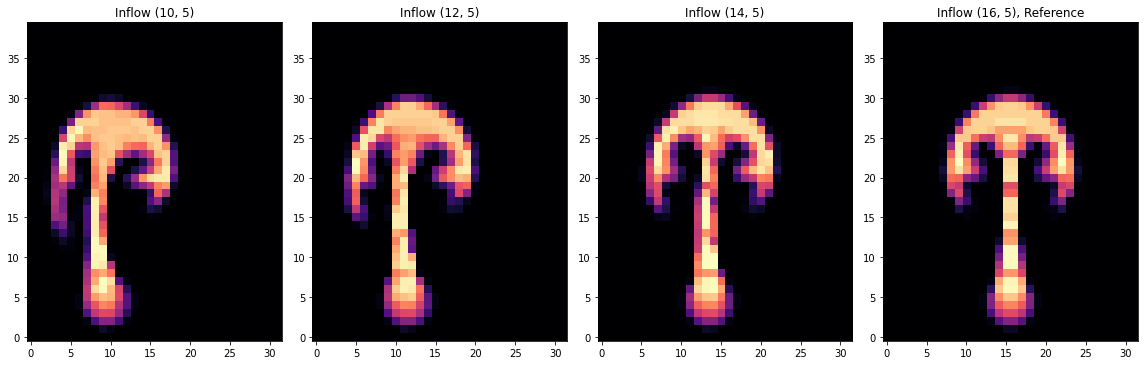

In [3]:
smoke = DOMAIN.scalar_grid(0)        # sampled at cell centers
velocity = DOMAIN.staggered_grid(0)  # sampled in staggered form at face centers 

def step(smoke, velocity):
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
  buoyancy_force = smoke * (0, 1) >> velocity
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _, _, _ = fluid.make_incompressible(velocity, DOMAIN)
  return smoke, velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  axes[i].imshow(smoke.values.inflow_loc[i].numpy('y,x'), origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}" + (", Reference" if i==3 else ""))
pylab.tight_layout()


The last image shows the state of the advected smoke fields after 20 simulation steps. The final smoke shape of simulation `[3]` with an inflow at `(16,5)`, with the straight plume on the far right, will be our **reference state** below. The initial velocity of the other three will be modified in the optimization procedure below to match this reference.

(As a small side note: phiflow tensors will keep track of their chain of operations using the backend they were created for. E.g. a tensor created with NumPy will keep using NumPy/SciPy operations unless a TensorFlow tensor is also passed to the same operation. Thus, it is a good idea to verify that tensors have the right `type` once in a while.)


## Gradients

Let's look at how to get gradients from our simulation. The first trivial step taken care of above was to include `phi.torch.flow` to import differentiable operators from which to build our simulator.

Now we want to optimize the initial velocities so that all simulations arrive at a final state that is similar to the right simulation where the inflow is located at `(16, 5)`.
To achieve this, we record the gradients during the simulation and define a simple $L^2$ based loss function. The loss function we'll use is given by $L = | u - u^* |^2$, where $s$ denotes the smoke density, and $u^*$ the reference state from the fourth simulation above. When evaluating the loss function we treat this reference state as an external constant via `field.stop_gradient()`.

It is important that our initial velocity has the `inflow_loc` dimension before we record the gradients, such that we have the full "mini-batch" of four versions of our velocity (three of which will be updated via gradients in our optimization later on). To get the approprate velocity tensor, we multiply a `staggered_grid` tensor from our domain object, with a tensor full of ones along the `inflow_loc` dimension.

phiflow provides a unified API for gradients across different platforms by using functions that need to return a loss values, in addition to optional state values. Below the `simulate` function computes the $L^2$ error outlined above and returns the evolved `smoke` and `velocity` states are 20 simulation steps.


In [4]:
initial_smoke = DOMAIN.grid(math.zeros(inflow_loc=4))
initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)

print("Velocity tensor shape: "+format(initial_velocity.shape))

def simulate(smoke: CenteredGrid, velocity: StaggeredGrid):
    for _ in range(20):
        smoke,velocity = step(smoke,velocity)
        
    #loss = field.l2_loss(diffuse.explicit(smoke - field.stop_gradient(smoke.inflow_loc[-1]), 1, 1, 10))
    loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]) )
    
    return loss, smoke, velocity


Velocity tensor shape: (inflow_loc=4, x=32, y=40, vector=2)


Then, we use `field.functional_gradient()` to obtain the gradient with respect to the initial velocity. Since the velocity is the second argument of the `simulate()` function, we pass `wrt=[1]`. (Note that there's also a `field.spatal_gradient` with computes derivatives of tensors along spatial dimensions like `x,y`.)

`functional_gradient` returns a gradient function, which we can evaluate with the initial states for smoke and velocity. 


In [24]:
sim_grad = field.functional_gradient(simulate, wrt=[1], get_output=False)
[velocity_grad] = sim_grad(initial_smoke, initial_velocity)

print("Gradient info " + format(velocity_grad))
velocity_grad.inflow_loc[0].values.vector[0] # one example, location 0, x component


Gradient info StaggeredGrid[(inflow_loc=4, x=32, y=40, vector=2), size=(32, 40) along vector, extrapolation=0]


(x=33, y=40) float32  -0.9229158759117126 < ... < 2.964700937271118

The last two lines just print some information about the resulting gradient field. Naturally, it has the same shape as the velocity itself: it's a staggered grid with four inflow locations. The last line shows how to access the x-components of one of the gradients.

We can directly use this to take a look at the content of the computed gradient. The following images show the `x` components (via `vector[0].values.numpy()`) of the staggered grid gradient in `velocity_grad`.


x components: (x=33, y=40) float32  0.0 < ... < 0.0


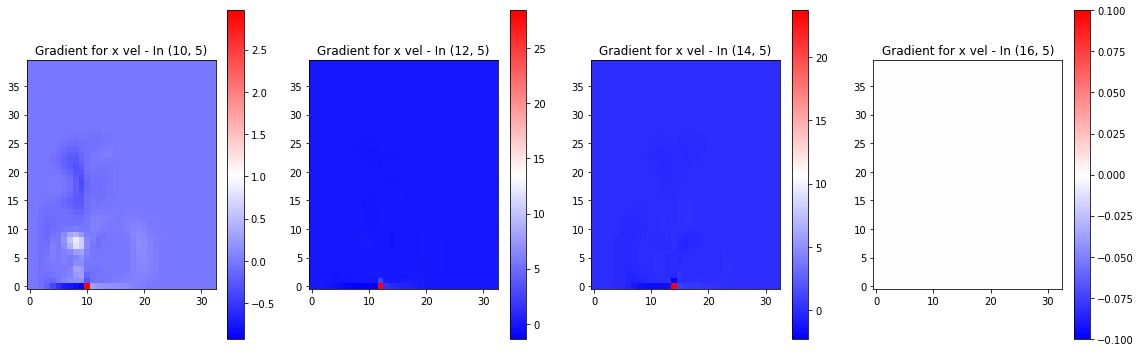

In [29]:
print("x components: "+format( velocity_grad.inflow_loc[i].values.vector[0] ))

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  im = axes[i].imshow(velocity_grad.inflow_loc[i].values.vector[0].numpy('y,x'), origin='lower', cmap='bwr')
  pylab.colorbar(im, ax=axes[i])
  axes[i].set_title(f"Gradient for x vel - In {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}")
pylab.tight_layout()



Not surprisingly, the fourth gradient on the left is zero (it's already matching the reference). The other three gradients have detected variations for the intial round inflow posiitons shown as positive and negative regions around the cirucular shape.

## Optimization

This is just the linearized change that points in the direction of an increasing loss. Now we can proceed by updating the initial velocities in the opposite direction to minimize the loss.

Note that this is a fairly tough task: we're producing different dynamics by changing the boundary conditions (the marker inflow position), and an optimizer should now find a single initial velocity state for each of the three simulations on the right, that gives the same state as simulation `0` above at $t=20$. Thus, after 20 update steps the simulation should reproduce a different set of boundary conditions from the velocity state. It would be much easier to simply change the position of the marker inflow to arrive at this goal, but -- to make things a bit more difficult and interesting here -- the inflow is _not_ a degree of freedom. The optimizer can only change the velocity $\mathbf{u}$ at time $t=0$.

The following cell re-evalutes the gradient function, and iterates a few times to optimize the initial velocities with a learning rate (step size) `LR`.

`field.functional_gradient` has a parameter `get_output` that determines whether the original results of the function (`simulate` here) are returned, or only the gradient. As it's interesting to track how the loss evolves over the course of the iterations, let's redefine the gradient function with `get_output=True`.


In [30]:
initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4) # reset
LR = 1e-02

sim_grad_wloss = field.functional_gradient(simulate, wrt=[1], get_output=True)

for optim_step in range(20):
    initial_smoke = DOMAIN.grid(math.zeros(inflow_loc=4))
    
    # sim_grad__wloss returns: [loss,s,v,velocity _grad] 
    sim_grad = field.functional_gradient(simulate, wrt=[1], get_output=True)
    [loss,s,v, velocity_grad] = sim_grad_wloss(initial_smoke, initial_velocity)

    print('Optimization step %d, loss: %f' % (optim_step,loss))

    initial_velocity = initial_velocity - LR * velocity_grad


Optimization step 0, loss: 62.215240
Optimization step 1, loss: 62.544254
Optimization step 2, loss: 62.061436
Optimization step 3, loss: 63.683025
Optimization step 4, loss: 64.774864
Optimization step 5, loss: 71.795349
Optimization step 6, loss: 74.215714
Optimization step 7, loss: 60.461643
Optimization step 8, loss: 65.317680
Optimization step 9, loss: 65.126022
Optimization step 10, loss: 65.193939
Optimization step 11, loss: 65.325432
Optimization step 12, loss: 65.471474
Optimization step 13, loss: 65.525093
Optimization step 14, loss: 64.756439
Optimization step 15, loss: 65.134476
Optimization step 16, loss: 64.554466
Optimization step 17, loss: 65.206245
Optimization step 18, loss: 66.495720
Optimization step 19, loss: 66.141006


The loss should have gone down significantly, from above 60 to below 40, and now we can also visualize the initial velocities that were obtained in the optimization.

The following images show the resulting three initial velocities (we're skipping the fourth set with `inflow_loc[0]` because it only contains zeros).


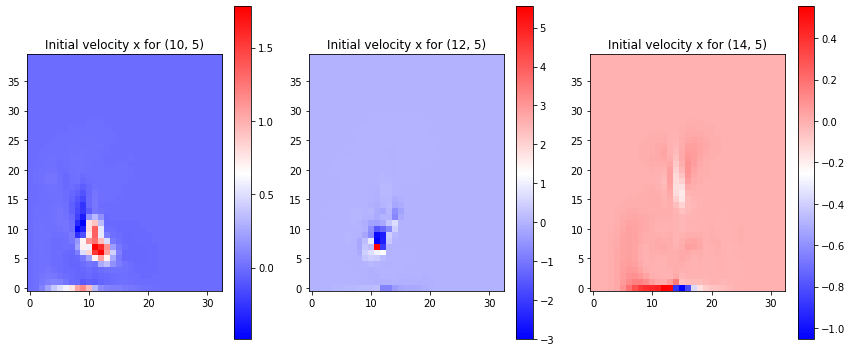

In [32]:
fig, axes = pylab.subplots(1, 3, figsize=(12, 5))
for i in range(INFLOW.shape.inflow_loc-1):
  im = axes[i].imshow(initial_velocity.inflow_loc[i].values.vector[0].numpy('y,x'), origin='lower', cmap='bwr')
  pylab.colorbar(im, ax=axes[i])
  axes[i].set_title(f"Initial velocity x for {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}")
pylab.tight_layout()

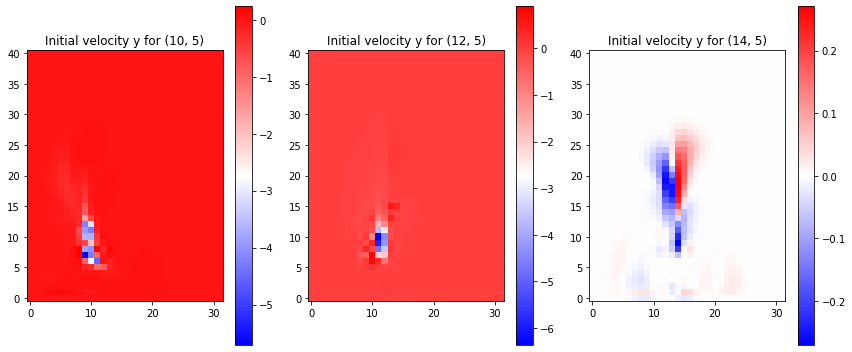

In [33]:
fig, axes = pylab.subplots(1, 3, figsize=(12, 5))
for i in range(INFLOW.shape.inflow_loc-1):
  im = axes[i].imshow(initial_velocity.inflow_loc[i].values.vector[1].numpy('y,x'), origin='lower', cmap='bwr')
  pylab.colorbar(im, ax=axes[i])
  axes[i].set_title(f"Initial velocity y for {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}")
pylab.tight_layout()

## Re-simulation

Most importantly, we can also visualize how the full simulation over the course of 20 steps turns out given the new initial conditions for each of the inflow locations. This is what happened internally at optimization time, and was measured by our loss function, but it's good to get an intuition for which solution the optimization has found.

Below, we re-run the forward simulation with the new initial conditions from `initial_velocity`:


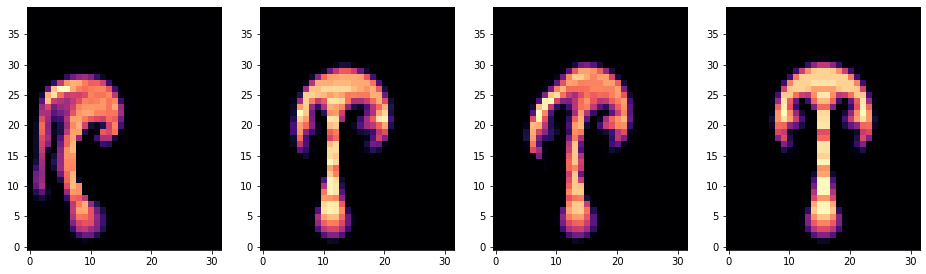

In [34]:
smoke = initial_smoke 
velocity = initial_velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  axes[i].imshow(smoke.values.inflow_loc[i].numpy('y,x'), origin='lower', cmap='magma')


Naturally, the image on the right is the same (this is simulation (3), our reference), and the other three simulations now exhibit a noticeable shift towards the right. This is especially visible for the far left simulation (0), which was strongly curved in its original state, and now has a shape that tries to match the straighter reference on the right. 

Note that all three simulations need to "work" with a fixed inflow, hence they cannot simply "produce" marker density out of the blue to match the target. Also each simulation needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. So the optimization goal is quite difficult, and it is not possible to exactly satisfy the constraints to match the reference simulation in this scenario. This is exactly what makes it an interesting test case, though.




## Conclusions

This example illustrated how the differentiable physics approach can easily be extended towards significanlty more 
complex PDEs. Above, we've optimized for a mini-batch of 20 steps of a full Navier-Stokes solver.

This is a powerful basis to bring NNs into the picture! As you might have noticed, our degrees of freedom were still a regular grid, and we've jointly solved a single inverse problem. There were three cases to solve, of course, but nonetheless no question of generalization and no neural network structure. Thus, in line with the PINN example of {doc}`physicalloss-code` we've not really dealt with a _machine learning_ task here. However, that will be the topic of the next chapters.


## Next Steps

Based on the code example above, we can recommend experimenting with the following:

- Modify the setup of the simulation to differ more strongly across the four instances, run longer, or use a finer spatial discretization (i.e. larger grid size). This will make the optimization problem tougher, and might not converge directly with this simple setup.

- For more complex cases, add a multi-resolution optimization, that first solves with a coarse discretization, and then uses this solution as an initial guess for a finer discretization. (Ideally, implement it with a loop that continuously refines the discretization.)
